In [1]:
import sys, os, time

import numpy as np
import matplotlib.pyplot as plt
import scipy as scp

import adi

In [2]:
# Pluto SDR setup
sample_rate = int(61.44e6) # single-channel: min: 520.83e3, max: 61.44e6 [SPS], dual-channel: min: 520.83e3, max: 30.72e6 [SPS]
center_freq = int(1825e6) # min: 70e6, max: 6e9 [Hz]
rx_gain = 50 # fc: 70 … 1300 [MHz] min: -1, max: 73, fc: 130 ... 4000 [MHz] min: -3, max: 71,  fc: 4000 … 6000 [MHz] min: -10 max: 62 [dB], For all freq: min: -1 max: 62 [dB]
buffer_size = int(2**12) # min: 2, max: 2**24 = 16 777 216 # number of samples returned per call to rx()/tx()
sdr = adi.Pluto("ip:192.168.2.1")

sdr.sample_rate = sample_rate
sdr.rx_rf_bandwidth = sample_rate # filter cutoff, just set it to be the same as sample rate for complex sampling
sdr.rx_lo = center_freq
sdr.rx_buffer_size = buffer_size

sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0 = rx_gain

In [3]:
# measure the time of a single snapshot capture and transfer
import time
start_time = time.time()
sdr.rx()
print("--- Time elapsed: %f ---" % (time.time() - start_time))

--- Time elapsed: 0.015277 ---


In [4]:
# Plot PSD 
n_snapshots = 100
psd_nfft = 4096
n_samp_per_seg = psd_nfft

# rx_samples = sdr.rx()
rx_sig_lst = []
for n in range(n_snapshots):
    rx_sig_lst.append(sdr.rx())
    
rx_sig_freq_arr, rx_sig_psd_arr = scp.signal.welch(np.concatenate(rx_sig_lst), fs=sample_rate, window='hann', noverlap=n_samp_per_seg // 2, 
                                                   nfft=psd_nfft, nperseg=n_samp_per_seg, return_onesided=False)
# sort the frequency bins
rx_sig_freq_arr = np.concatenate((rx_sig_freq_arr[-(psd_nfft // 2):], rx_sig_freq_arr[0:psd_nfft // 2]))
rx_sig_psd_arr = np.concatenate((rx_sig_psd_arr[-(psd_nfft // 2):], rx_sig_psd_arr[0:psd_nfft // 2]))

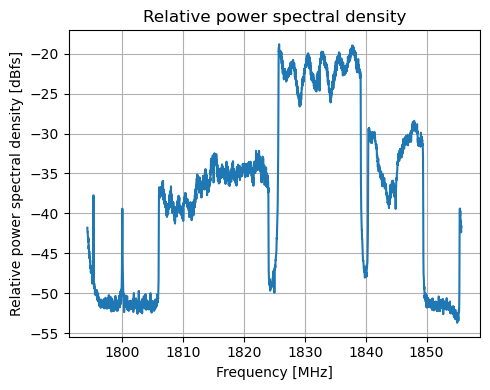

In [6]:
fig1, ax1 = plt.subplots(1, 1, figsize=(5, 4 ))

ax1.plot((np.array(rx_sig_freq_arr) + center_freq) / 1e6, 10*np.log10(rx_sig_psd_arr))
ax1.grid()

ax1.set_title("Relative power spectral density")
ax1.set_xlabel("Frequency [MHz]")
ax1.set_ylabel("Relative power spectral density [dBfs]")
plt.tight_layout()

plt.savefig("figs/rx_psd.png", dpi=600, bbox_inches='tight')
plt.show()

In [7]:
# Wideband sweep
freq_start = 2300e6
freq_stop = 2600e6
psd_nfft = 2**12 # should be a power of two for fast computation
n_snapshots = 2**10 # also a power of 2 to keep the buffer size 

freq_bin_res = sample_rate / psd_nfft
print("Frequency bin resolution: %1.1f [KHz]" % (freq_bin_res / 1e3))
buffer_size = psd_nfft * n_snapshots # min: 2, max: 2**24 = 16 777 216 # number of samples returned per call to rx()/tx()

center_freq_lst = np.arange(freq_start + sample_rate // 2, freq_stop + sample_rate // 2, sample_rate)

# Pluto SDR setup
sample_rate = int(61.44e6) # single-channel: min: 520.83e3, max: 61.44e6 [SPS], dual-channel: min: 520.83e3, max: 30.72e6 [SPS]
rx_gain = 50 # fc: 70 … 1300 [MHz] min: -1, max: 73, fc: 130 ... 4000 [MHz] min: -3, max: 71,  fc: 4000 … 6000 [MHz] min: -10 max: 62 [dB], For all freq: min: -1 max: 62 [dB]

sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = int(61.44e6) # single-channel: min: 520.83e3, max: 61.44e6 [SPS], dual-channel: min: 520.83e3, max: 30.72e6 [SPS]
sdr.rx_rf_bandwidth = int(61.44e6) 
sdr.rx_buffer_size = buffer_size # min: 2, max: 2**24 = 16 777 216 # number of samples returned per call to rx()/tx()

sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0 = rx_gain # fc: 70 … 1300 [MHz] min: -1, max: 73, fc: 130 ... 4000 [MHz] min: -3, max: 71,  fc: 4000 … 6000 [MHz] min: -10 max: 62 [dB], For all freq: min: -1 max: 62 [dB]

freq_arr = []
psd_arr = []

for c_freq_idx, center_freq in enumerate(center_freq_lst):
    
    sdr.rx_lo = int(center_freq)
    sdr.rx_destroy_buffer() # clears the RX buffer, make the new settings take effect
    rx_sig = sdr.rx()

    rx_sig_freq_arr, rx_sig_psd_arr = scp.signal.welch(rx_sig, fs=sample_rate, window='hann', noverlap=psd_nfft // 2, 
                                                   nfft=psd_nfft, nperseg=psd_nfft, return_onesided=False)

    sorted_rx_sig_freq_arr = np.concatenate((rx_sig_freq_arr[-(psd_nfft // 2):], rx_sig_freq_arr[0:psd_nfft // 2])) + center_freq
    sorted_rx_sig_psd_arr = np.concatenate((rx_sig_psd_arr[-(psd_nfft // 2):], rx_sig_psd_arr[0:psd_nfft // 2]))
    
    # trim the frequency range
    if c_freq_idx == len(center_freq_lst) - 1:
        sel_idx = np.where(sorted_rx_sig_freq_arr <= freq_stop + freq_bin_res // 2)
        sorted_rx_sig_freq_arr = sorted_rx_sig_freq_arr[sel_idx]
        sorted_rx_sig_psd_arr = sorted_rx_sig_psd_arr[sel_idx]
        
    freq_arr.append(sorted_rx_sig_freq_arr)
    psd_arr.append(sorted_rx_sig_psd_arr)


Frequency bin resolution: 15.0 [KHz]


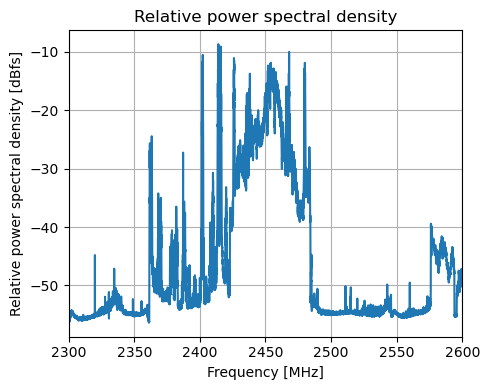

In [10]:
fig1, ax1 = plt.subplots(1, 1, figsize=(5, 4 ))
ax1.plot(np.concatenate(freq_arr) / 1e6, 10*np.log10(np.concatenate(psd_arr)))
ax1.grid()

ax1.set_title("Relative power spectral density")
ax1.set_xlabel("Frequency [MHz]")
ax1.set_ylabel("Relative power spectral density [dBfs]")
ax1.set_xlim([freq_start / 1e6, freq_stop / 1e6])
plt.tight_layout()

plt.savefig("figs/rx_psd_wideband.png", dpi=600, bbox_inches='tight')
plt.show()

In [11]:
# Wideband sweep
freq_start = 300e6
freq_stop = 3000e6
psd_nfft = 2**12 # should be a power of two for fast computation
n_snapshots = 2**10 # also a power of 2 to keep the buffer size 

freq_bin_res = sample_rate / psd_nfft
print("Frequency bin resolution: %1.1f [KHz]" % (freq_bin_res / 1e3))
buffer_size = psd_nfft * n_snapshots # min: 2, max: 2**24 = 16 777 216 # number of samples returned per call to rx()/tx()

center_freq_lst = np.arange(freq_start + sample_rate // 2, freq_stop + sample_rate // 2, sample_rate)

# Pluto SDR setup
sample_rate = int(61.44e6) # single-channel: min: 520.83e3, max: 61.44e6 [SPS], dual-channel: min: 520.83e3, max: 30.72e6 [SPS]
rx_gain = 50 # fc: 70 … 1300 [MHz] min: -1, max: 73, fc: 130 ... 4000 [MHz] min: -3, max: 71,  fc: 4000 … 6000 [MHz] min: -10 max: 62 [dB], For all freq: min: -1 max: 62 [dB]

sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = int(61.44e6) # single-channel: min: 520.83e3, max: 61.44e6 [SPS], dual-channel: min: 520.83e3, max: 30.72e6 [SPS]
sdr.rx_rf_bandwidth = int(61.44e6) 
sdr.rx_buffer_size = buffer_size # min: 2, max: 2**24 = 16 777 216 # number of samples returned per call to rx()/tx()

sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0 = rx_gain # fc: 70 … 1300 [MHz] min: -1, max: 73, fc: 130 ... 4000 [MHz] min: -3, max: 71,  fc: 4000 … 6000 [MHz] min: -10 max: 62 [dB], For all freq: min: -1 max: 62 [dB]

# estimate the measurment time
start_time = time.time()

rx_sig = sdr.rx()
rx_sig_freq_arr, rx_sig_psd_arr = scp.signal.welch(rx_sig, fs=sdr.sample_rate, window='hann', noverlap=psd_nfft // 2, 
                                                   nfft=psd_nfft, nperseg=psd_nfft, return_onesided=False)

time_elapsed = time.time() - start_time

print("Estimated measurment time: %1.2f [s]" % (time_elapsed * len(center_freq_lst)))


def measure_psd_wideband(sdr_obj, center_freq_lst, psd_nfft):
    freq_arr = []
    psd_arr = []
    
    for c_freq_idx, center_freq in enumerate(center_freq_lst):

        sdr_obj.rx_lo = int(center_freq)
        sdr_obj.rx_destroy_buffer() # clears the RX buffer, make the new settings take effect
        rx_sig = sdr_obj.rx()

        rx_sig_freq_arr, rx_sig_psd_arr = scp.signal.welch(rx_sig, fs=sdr.sample_rate, window='hann', noverlap=psd_nfft // 2, 
                                                       nfft=psd_nfft, nperseg=psd_nfft, return_onesided=False)

        sorted_rx_sig_freq_arr = np.concatenate((rx_sig_freq_arr[-(psd_nfft // 2):], rx_sig_freq_arr[0:psd_nfft // 2])) + center_freq
        sorted_rx_sig_psd_arr = np.concatenate((rx_sig_psd_arr[-(psd_nfft // 2):], rx_sig_psd_arr[0:psd_nfft // 2]))

        # trim the frequency range
        if c_freq_idx == len(center_freq_lst) - 1:
            sel_idx = np.where(sorted_rx_sig_freq_arr <= freq_stop + freq_bin_res // 2)
            sorted_rx_sig_freq_arr = sorted_rx_sig_freq_arr[sel_idx]
            sorted_rx_sig_psd_arr = sorted_rx_sig_psd_arr[sel_idx]

        freq_arr.append(sorted_rx_sig_freq_arr)
        psd_arr.append(sorted_rx_sig_psd_arr)
    
    return freq_arr, psd_arr

start_time = time.time()
freq_arr, psd_arr = measure_psd_wideband(sdr, center_freq_lst, psd_nfft)
sweep_time = time.time() - start_time
print("Actual measurment time: %1.2f [s]" % (sweep_time))


Frequency bin resolution: 15.0 [KHz]
Estimated measurment time: 51.09 [s]
Actual measurment time: 52.42 [s]


In [12]:
# saving the data as binary file is over 2.5 times more memory efficient
import datetime

n_sweeps = 10
print("Total measurment time: %1.2f [s]" % (sweep_time * n_sweeps))

save_freq_arr_once = True

datetime_arr = []
for sweep_idx in range(n_sweeps):
    
    start_datetime = datetime.datetime.now()
    freq_arr, psd_arr = measure_psd_wideband(sdr, center_freq_lst, psd_nfft)
    stop_datetime = datetime.datetime.now()
    
    datetime_diff = stop_datetime - start_datetime
    mid_measurment_datetime = start_datetime  + datetime_diff / 2
    datetime_arr.append(mid_measurment_datetime)
    
    np.save("data/datetime_arr.npy", datetime_arr)
    
    if save_freq_arr_once:
        np.save("data/freq_arr.npy", np.concatenate(freq_arr))
        save_freq_arr_once = False
        
    np.save("data/psd_arr_%d.npy" %(sweep_idx), np.concatenate(psd_arr))

Total measurment time: 524.15 [s]


In [14]:
# read the measurment data and plot
datetime_arr = np.load("data/datetime_arr.npy", allow_pickle=True)
freq_arr = np.load("data/freq_arr.npy", allow_pickle=True)
psd_arr_per_datetime_lst = []

for sweep_idx in range(n_sweeps):
    # convert to dB
    psd_arr = 10*np.log10(np.load("data/psd_arr_%d.npy" %(sweep_idx)))
    psd_arr_per_datetime_lst.append(psd_arr)
    
# transform the psd list to matrix for 2D plot
psd_waterfall_mat = np.vstack(psd_arr_per_datetime_lst)

<class 'datetime.datetime'>


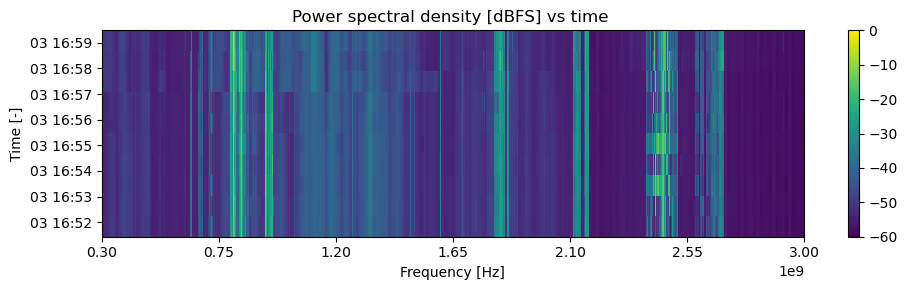

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

im1 = ax.imshow(psd_waterfall_mat, extent=[np.min(freq_arr), np.max(freq_arr), np.min(datetime_arr), np.max(datetime_arr)], vmin=-60, vmax=0, interpolation='None', aspect='auto')
ax.set_title("Power spectral density [dBFS] vs time ")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Time [-]")

x_ticks = np.linspace(np.min(freq_arr), np.max(freq_arr), 7, endpoint=True)
ax.set_xticks(x_ticks)

fig.colorbar(im1, orientation='vertical')

plt.tight_layout()
plt.savefig("figs/waterfall_psd_sweep.png", dpi=600, bbox_inches='tight')
plt.show()